In [1]:
import os
import parse
import pickle
import copy
import math

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.simple_mnist import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/lbfgsm/cff_mnist_relu.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                row = {'filtration':f, 'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                row = {'filtration':f, 'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df)

In [5]:
def create_sample_graphs(df):
    sample_graphs = []
    diagrams = []
    for s in range(df.shape[0]):
        print(s)
        subgraphs = {}
        f = df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgms = dion.init_diagrams(m,f)
        diagrams.append(dgms[0])
        for i,c in enumerate(m):
            if len(c) == 2:
#                 print(" + ".join(["%d * %s" % (x.element, f[x.index]) for x in c]))
                if f[c[0].index][0] in subgraphs:
                    subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(f[c[0].index][0]):
                            v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        subgraphs[f[c[0].index][0]] = g

        sample_graphs.append(subgraphs)
    return sample_graphs, diagrams


def create_lifetimes(dgms):
    return [[pt.birth - pt.death for pt in dgm if pt.death < np.inf] for dgm in dgms]

In [6]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/cff_mnist_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [7]:
res_df = create_filtrations(model, 1, 10)

Filtration: 0
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 65841
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 87895
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 43064
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 99318
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76795
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 48402
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79645
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69799
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96099
Sorting filtration...
Filtration: 9
h1_id_start 78

In [8]:
adv_df = create_adversary_filtrations(model, 1, 10, adversaries)

torch.Size([1150, 1, 28, 28]) torch.Size([1150])
Filtration: 0
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142910
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 160303
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 127625
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 144324
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 155315
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142823
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175039
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140889
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size

In [9]:
adv_df.head()

,class,filtration,loss,prediction
0,7,"[(3701), (3718), (3701, 3718), (3710), (3716),...",2.097488,3
1,2,"[(3701), (3718), (3701, 3718), (3716), (3701, ...",1.839955,1
2,1,"[(3690), (3723), (3690, 3723), (3695), (3695, ...",2.935034,6
3,0,"[(3690), (3723), (3690, 3723), (3675), (3715),...",1.826473,6
4,4,"[(3684), (3717), (3684, 3717), (3715), (3684, ...",3.121661,9


In [10]:
sample_graphs, dgms = create_sample_graphs(res_df)
adv_sample_graphs, adv_dgms = create_sample_graphs(adv_df)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [11]:
lifetimes = create_lifetimes(dgms)
adv_lifetimes = create_lifetimes(adv_dgms)

In [12]:
np.mean(lifetimes[0])

0.1380422092833609

In [13]:
np.mean(adv_lifetimes[0])

0.048577032497373045

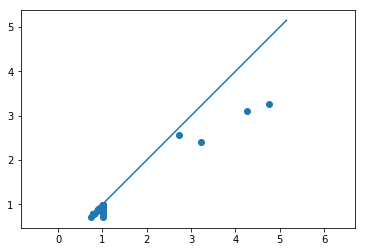

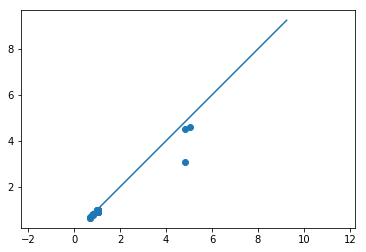

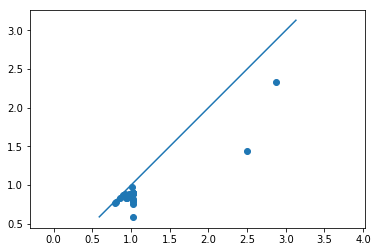

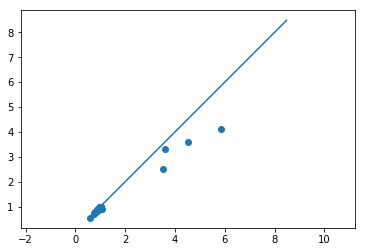

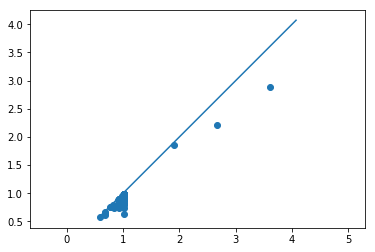

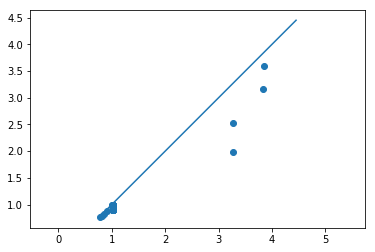

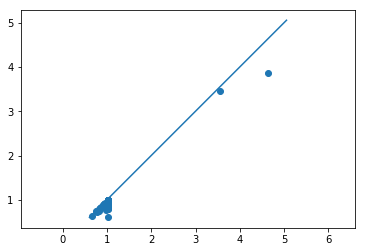

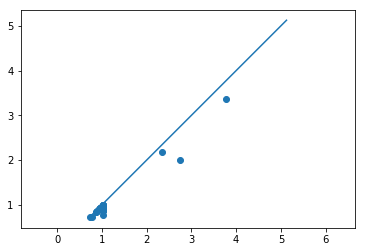

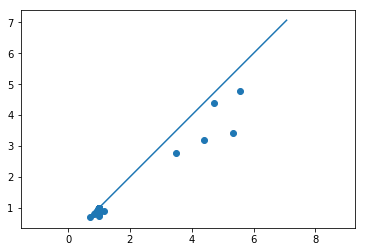

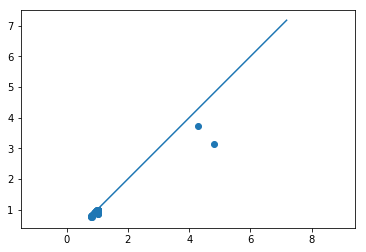

In [14]:
for dgm in dgms:
    dion.plot.plot_diagram(dgm, show=True)

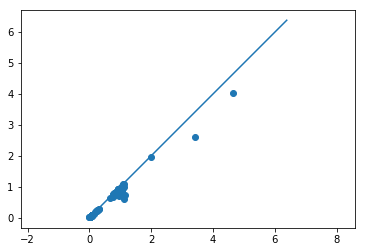

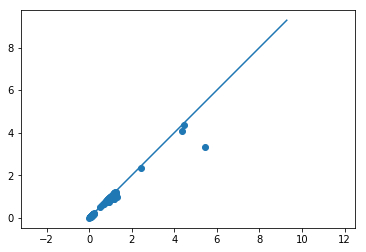

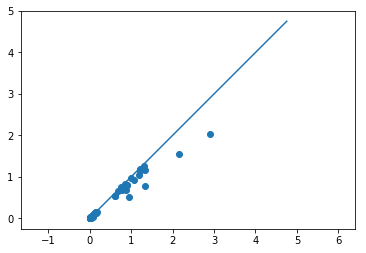

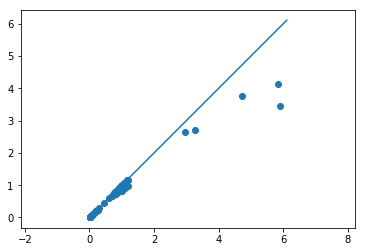

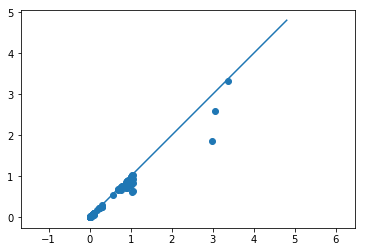

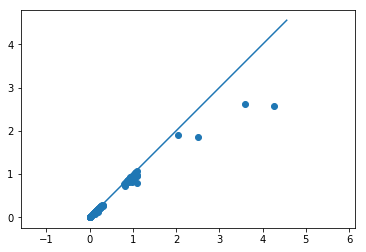

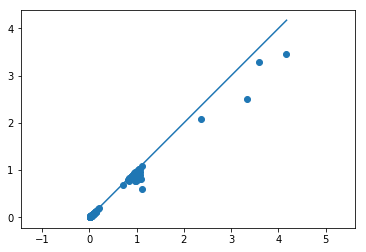

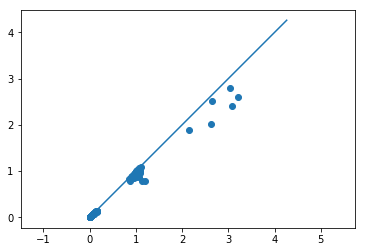

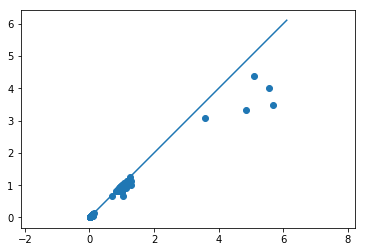

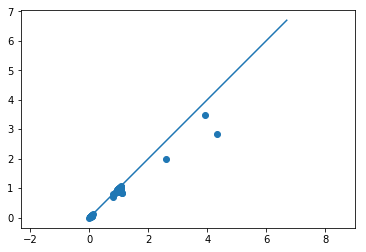

In [15]:
for adv_dgm in adv_dgms:
    dion.plot.plot_diagram(adv_dgm, show=True)

In [18]:
thru = 5
all_gois = []
for i in range(len(sample_graphs)):
    print(i)
    ks = list(sample_graphs[i].keys())
    thru = math.ceil(.25*len(ks))
    a = [sample_graphs[i][k] for k in ks[-thru:]]
    all_gois.append(nx.compose_all(a))
    
adv_all_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    ks = list(adv_sample_graphs[i].keys())
    thru = math.ceil(.25*len(ks))
    a = [adv_sample_graphs[i][k] for k in ks[-thru:]]
    adv_all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


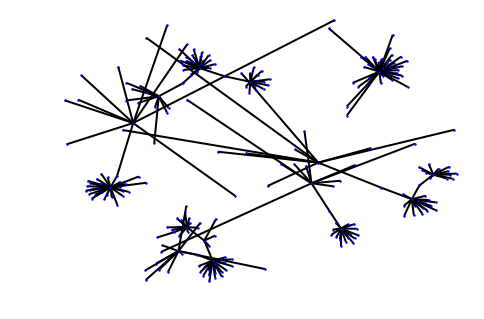

In [19]:
options = {
    'node_color': 'blue',
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(all_gois[2], **options)

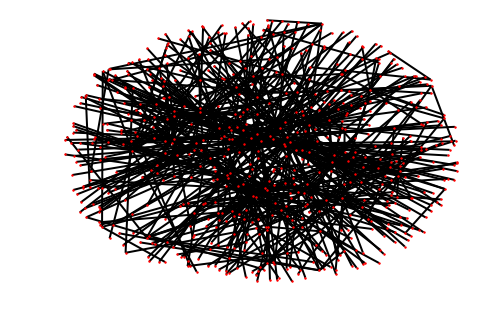

In [20]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_all_gois[2], **options)

In [21]:
# for a in sample_graphs[2]:
#     print(a)
#     for e in sample_graphs[2][a].edges(data=True):
#         print(e)

3701


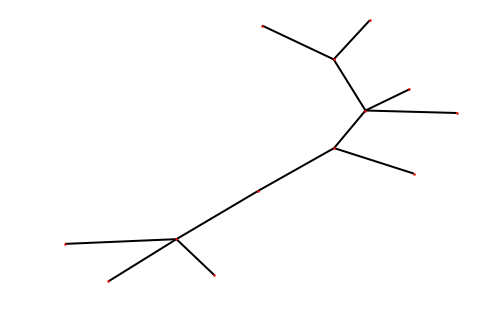

3701


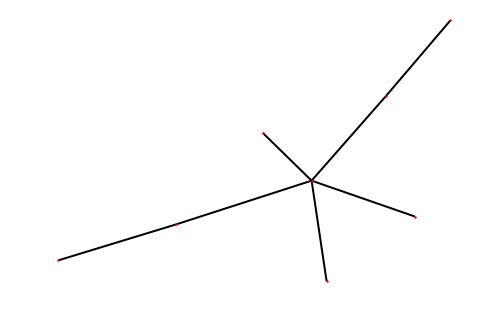

3677


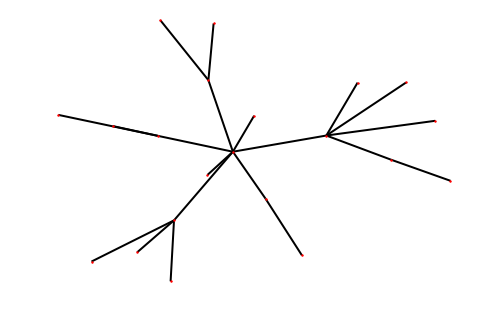

3701


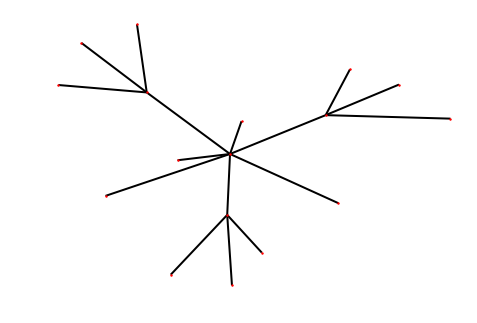

3684


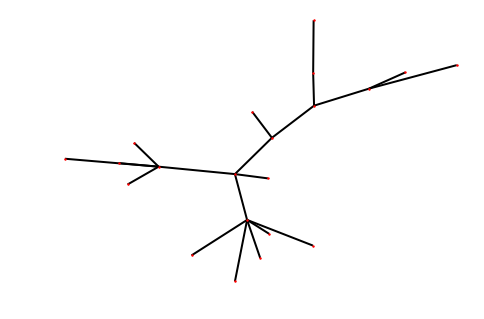

3710


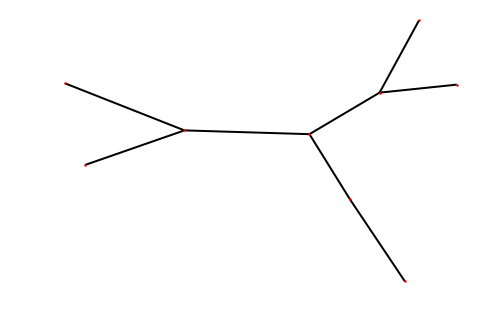

3668


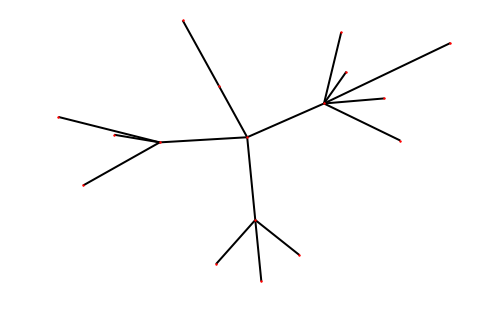

3713


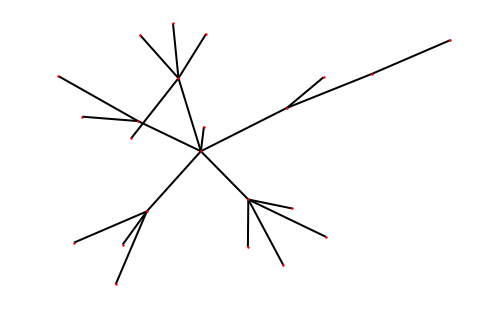

3712


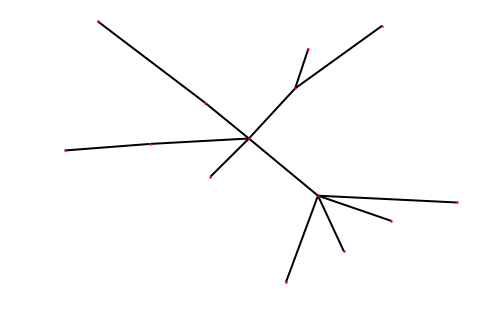

3703


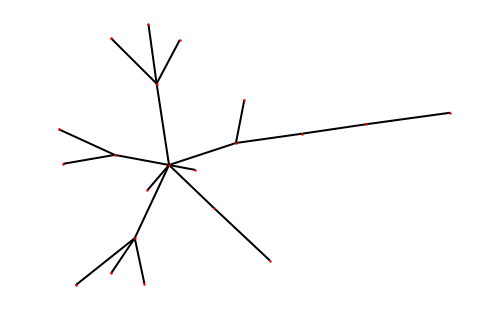

In [22]:
for g in sample_graphs:
    k = list(g.keys())[0]
    print(k)
    nx.draw_spring(g[k], **options)
    plt.show()

3701


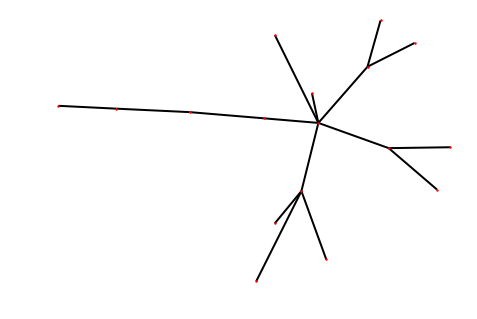

3701


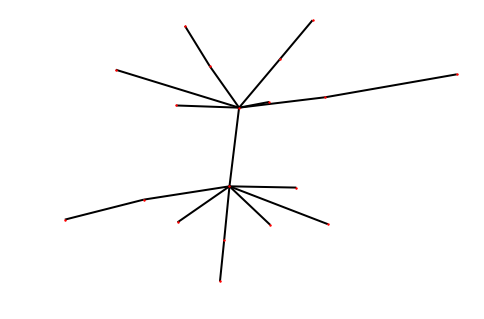

3690


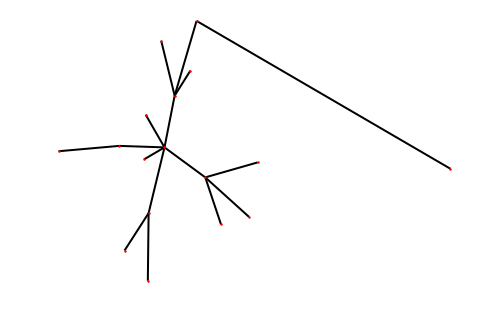

3690


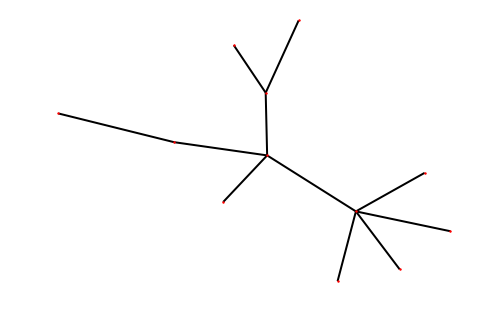

3684


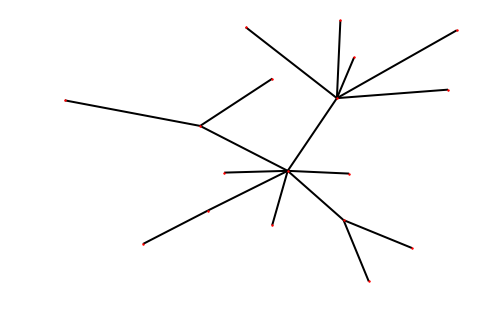

3710


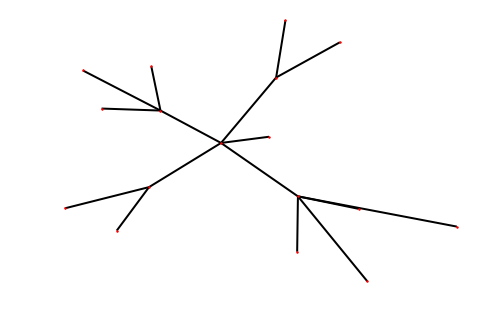

3674


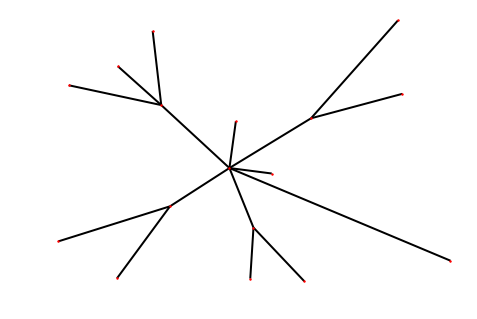

3713


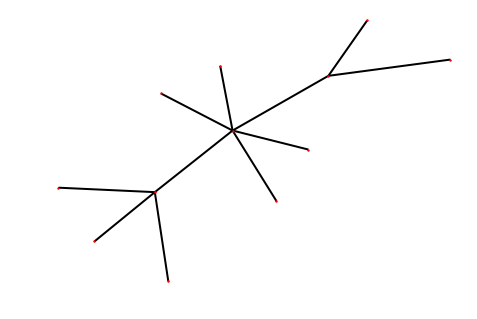

3712


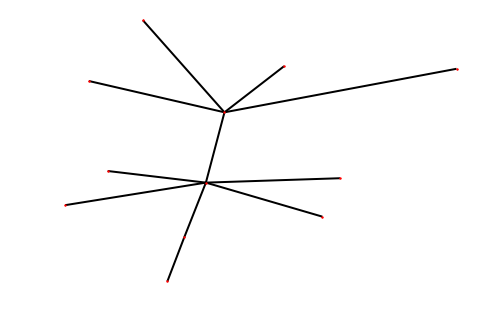

3703


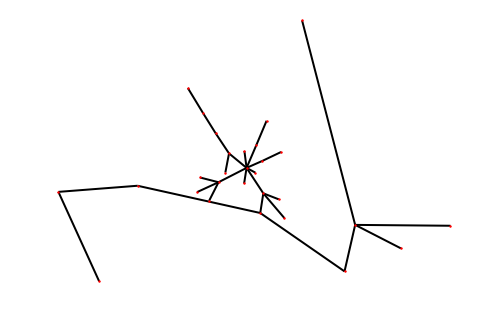

In [23]:
for g in adv_sample_graphs:
    k = list(g.keys())[0]
    print(k)
    nx.draw_spring(g[k], **options)
    plt.show()

In [24]:
ids = model.layerwise_ids()
ids

[range(0, 784), range(784, 3664), range(3664, 3714), range(3714, 3724)]

In [25]:
h1s = list(ids[1])
h2s = list(ids[2])
h3s = list(ids[3])
fh1 = h1s[0]
fh2 = h2s[0]
fh3 = h3s[0]

In [40]:
def predict_subgraph(model, up_to, subgraphs, inc_by=1.5, dec_by=.5):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=1, shuffle=False, **kwargs)

    test_loss = 0
    correct = 0
    s = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            m = copy.deepcopy(model)
            m.eval()
            fc1 = m.fc1.weight.data.cpu().detach().numpy()
            new_fc1 = fc1*dec_by
            fc2 = m.fc2.weight.data.cpu().detach().numpy()
            new_fc2 = fc2*dec_by
            
            this_d = data.numpy().reshape(-1)
            this_new_d = this_d*dec_by
            for e in subgraphs[s].edges(data=True):
                if e[0] < this_d.shape[0]:
                    this_new_d[e[0]] = this_d[e[0]]*inc_by
                if e[1] < this_d.shape[0]:
                    this_new_d[e[1]] = this_d[e[1]]*inc_by
                if e[0] in h1s and e[1] in h2s:
                    new_fc1[e[1]-fh2,e[0]-fh1] = fc1[e[1]-fh2,e[0]-fh1]*inc_by
                if e[0] in h2s and e[1] in h3s:
                    new_fc2[e[1]-fh3,e[0]-fh2] = fc2[e[1]-fh3,e[0]-fh2]*inc_by
                            
            m.state_dict()['fc1.weight'].copy_(torch.Tensor(new_fc1))
            m.state_dict()['fc2.weight'].copy_(torch.Tensor(new_fc2))
#             data, target = torch.Tensor(this_new_d.reshape((1,1,28,28))).to(device), target.to(device)
            output, hiddens = m(data, hiddens=True)
            ex = torch.exp(output)
            row_sums = torch.sum(ex, 1) # normalization 
            row_sums = row_sums.repeat(1, 10) # expand to same size as out
            out = torch.div( ex , row_sums )
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            row = {'loss':test_loss, 'class':target.cpu().numpy()[0], 'prediction':pred.cpu().numpy()[0][0], 'prob':out[0,pred].cpu().numpy()[0][0]}
            res_df.append(row)

            s += 1
            if s >= up_to:
                break

    return pd.DataFrame(res_df)


def adv_predict_subgraph(model, up_to, subgraphs, adversaries, inc_by=1.5, dec_by=.5):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=1, shuffle=False)

    test_loss = 0
    correct = 0
    s = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            m = copy.deepcopy(model)
            m.eval()
            fc1 = m.fc1.weight.data.cpu().detach().numpy()
            new_fc1 = fc1*dec_by
            fc2 = m.fc2.weight.data.cpu().detach().numpy()
            new_fc2 = fc2*dec_by
            
            this_d = data.numpy().reshape(-1)
            this_new_d = this_d*dec_by
            for e in subgraphs[s].edges(data=True):
                if e[0] < this_d.shape[0]:
                    this_new_d[e[0]] = this_d[e[0]]*inc_by
                if e[1] < this_d.shape[0]:
                    this_new_d[e[1]] = this_d[e[1]]*inc_by
                if e[0] in h1s and e[1] in h2s:
                    new_fc1[e[1]-fh2,e[0]-fh1] = fc1[e[1]-fh2,e[0]-fh1]*inc_by
                if e[0] in h2s and e[1] in h3s:
                    new_fc2[e[1]-fh3,e[0]-fh2] = fc2[e[1]-fh3,e[0]-fh2]*inc_by
                            
            m.state_dict()['fc1.weight'].copy_(torch.Tensor(new_fc1))
            m.state_dict()['fc2.weight'].copy_(torch.Tensor(new_fc2))
#             data, target = torch.Tensor(this_new_d.reshape((1,1,28,28))).to(device), target.to(device)
            output, hiddens = m(data, hiddens=True)
            ex = torch.exp(output)
            row_sums = torch.sum(ex, 1) # normalization 
            row_sums = row_sums.repeat(1, 10) # expand to same size as out
            out = torch.div( ex , row_sums )
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            row = {'loss':test_loss, 'class':target.cpu().numpy()[0], 'prediction':pred.cpu().numpy()[0][0], 'prob':out[0,pred].cpu().numpy()[0][0]}
            res_df.append(row)

            s += 1
            if s >= up_to:
                break

    return pd.DataFrame(res_df)

In [41]:
sdf = predict_subgraph(model, 10, all_gois, inc_by=.1, dec_by=1)
print('Accuracy:', sdf[sdf['class'] == sdf['prediction']].shape[0]/sdf.shape[0])
sdf.head(10)

Accuracy: 1.0


,class,loss,prediction,prob
0,7,0.001125,7,0.998875
1,2,0.000904,2,0.999096
2,1,0.001694,1,0.998308
3,0,0.000076,0,0.999924
4,4,0.007468,4,0.992560
5,1,0.000574,1,0.999426
6,4,0.000535,4,0.999465
7,9,0.000786,9,0.999215
8,5,0.098130,5,0.906531
9,9,0.005390,9,0.994624


In [42]:
res_df.head(10)

,class,filtration,loss,prediction
0,7,"[(3701), (3718), (3701, 3718), (3710), (3716),...",0.001125,7
1,2,"[(3701), (3718), (3701, 3718), (3716), (3701, ...",0.000904,2
2,1,"[(3677), (3717), (3677, 3717), (3716), (3677, ...",0.001705,1
3,0,"[(3701), (3718), (3701, 3718), (3675), (3715),...",0.000076,0
4,4,"[(3684), (3717), (3684, 3717), (3668), (3668, ...",0.007468,4
5,1,"[(3710), (3716), (3710, 3716), (3677), (3717),...",0.000662,1
6,4,"[(3668), (3717), (3668, 3717), (3674), (3719),...",0.000535,4
7,9,"[(3713), (3722), (3713, 3722), (3721), (3713, ...",0.000952,9
8,5,"[(3712), (3720), (3712, 3720), (3716), (3712, ...",0.098130,5
9,9,"[(3703), (3714), (3703, 3714), (3720), (3703, ...",0.005390,9


In [43]:
inc_bys = np.linspace(0, .0001, num=10)
dec_bys = np.linspace(1, 2, num=10)
best_acc = 0.0
best_inc = -1
best_dec = -1
for i in range(inc_bys.shape[0]):
    inc = inc_bys[i]
    print(i, inc)
    for dec in dec_bys:
        adv_sdf = adv_predict_subgraph(model, 10, adv_all_gois, adversaries, inc_by=inc, dec_by=dec)
        acc = adv_sdf[adv_sdf['class'] == adv_sdf['prediction']].shape[0]/adv_sdf.shape[0]
        print(acc)
        if acc > best_acc:
            best_acc = acc
            best_inc = inc
            best_dec = dec
print('Best Accuracy: {}, Best Inc: {}, Best Dec: {}'.format(best_acc, best_inc, best_dec))
sdf = predict_subgraph(model, 10, all_gois, inc_by=best_inc, dec_by=best_dec)
print('Unaltered Accuracy:', sdf[sdf['class'] == sdf['prediction']].shape[0]/sdf.shape[0])

0 0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1 1.1111111111111112e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2 2.2222222222222223e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3 3.3333333333333335e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4 4.4444444444444447e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5 5.555555555555556e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6 6.666666666666667e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7 7.777777777777778e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8 8.888888888888889e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9 0.0001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Best Accuracy: 0.0, Best Inc: -1, Best Dec: -1
Unaltered Accuracy: 0.0


In [37]:
adv_sdf = adv_predict_subgraph(model, 10, adv_all_gois, adversaries, inc_by=best_inc, dec_by=best_dec)
print('Accuracy:', adv_sdf[adv_sdf['class'] == adv_sdf['prediction']].shape[0]/adv_sdf.shape[0])
adv_sdf.head(10)

Accuracy: 0.1


,class,loss,prediction,prob
0,7,1.977008,3,0.858853
1,2,1.659296,1,0.809338
2,1,2.927889,6,0.941448
3,0,2.751375,6,0.935247
4,4,2.978923,9,0.947791
5,1,4.997931,7,0.992413
6,4,1.206938,8,0.693942
7,9,0.948256,2,0.607436
8,5,2.315617,6,0.899856
9,9,0.657983,9,0.517895


In [31]:
adv_df.head(10)

,class,filtration,loss,prediction
0,7,"[(3701), (3718), (3701, 3718), (3710), (3716),...",2.097488,3
1,2,"[(3701), (3718), (3701, 3718), (3716), (3701, ...",1.839955,1
2,1,"[(3690), (3723), (3690, 3723), (3695), (3695, ...",2.935034,6
3,0,"[(3690), (3723), (3690, 3723), (3675), (3715),...",1.826473,6
4,4,"[(3684), (3717), (3684, 3717), (3715), (3684, ...",3.121661,9
5,1,"[(3710), (3716), (3710, 3716), (3695), (3723),...",5.798882,7
6,4,"[(3674), (3719), (3674, 3719), (3668), (3717),...",1.430095,8
7,9,"[(3713), (3722), (3713, 3722), (3696), (3718),...",1.063661,2
8,5,"[(3712), (3720), (3712, 3720), (3666), (3721),...",2.809667,6
9,9,"[(3703), (3714), (3703, 3714), (3720), (3703, ...",1.206141,8


In [32]:
res_df.head(10)

,class,filtration,loss,prediction
0,7,"[(3701), (3718), (3701, 3718), (3710), (3716),...",0.001125,7
1,2,"[(3701), (3718), (3701, 3718), (3716), (3701, ...",0.000904,2
2,1,"[(3677), (3717), (3677, 3717), (3716), (3677, ...",0.001705,1
3,0,"[(3701), (3718), (3701, 3718), (3675), (3715),...",0.000076,0
4,4,"[(3684), (3717), (3684, 3717), (3668), (3668, ...",0.007468,4
5,1,"[(3710), (3716), (3710, 3716), (3677), (3717),...",0.000662,1
6,4,"[(3668), (3717), (3668, 3717), (3674), (3719),...",0.000535,4
7,9,"[(3713), (3722), (3713, 3722), (3721), (3713, ...",0.000952,9
8,5,"[(3712), (3720), (3712, 3720), (3716), (3712, ...",0.098130,5
9,9,"[(3703), (3714), (3703, 3714), (3720), (3703, ...",0.005390,9


In [33]:
# Best Accuracy: 0.3, Best Inc: 0.20506122448979594, Best Dec: 0.556 Unaltered Accuracy: 0.7
# :10 Best Accuracy: 0.3, Best Inc: 0.021387755102040818, Best Dec: 0.667 Unaltered Accuracy: 0.6
# :10 Best Accuracy: 0.3, Best Inc: 0.004948979591836736, Best Dec: 0.7896842105263158 Unaltered Accuracy: 0.6
# :10, No input alter: Best Accuracy: 0.3, Best Inc: 0.1, Best Dec: 1.1555555555555557 Unaltered Accuracy: 0.8